In [29]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC

import numpy as np
import pandas as pd

from joblib import Parallel, delayed

import string

In [32]:
df = pd.read_csv('../data/interim/last_one.csv')

# Use a fraction of the data for faster testing
df = df.sample(frac=0.1, random_state=42)

In [34]:
# keep only joke_new and score_class
df = df[['joke_new', 'score_class']]
# Change name to text and label
df.columns = ['text', 'label']

In [35]:
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

# We can build our custom transformer to preprocess the text data
# This will allow us to use the sklearn pipeline API

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words, wnl):
        self.stop_words = stop_words
        self.wnl = wnl

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return Parallel(n_jobs=-1)(delayed(self.preprocess_text)(text) for text in X)

    def preprocess_text(self, text):
        """
        Preprocess text data by removing stop words, and lemmatizing words.
        """
        text = text.lower()
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in self.stop_words]
        tokens = [self.wnl.lemmatize(t) for t in tokens]
        text = ' '.join(tokens)
        return text
    
logreg_clf = Pipeline([
    ('preprocessor', TextPreprocessor(stop_words, wnl)),
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=5000)),
    ('classifier', LogisticRegression(n_jobs=-1, random_state=42, max_iter=1000))
])

bayes_clf = Pipeline([
    ('preprocessor', TextPreprocessor(stop_words, wnl)),
    ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1, 3))),
    ('classifier', MultinomialNB(alpha=1))
])

svm_clf = Pipeline([
    ('preprocessor', TextPreprocessor(stop_words, wnl)),
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
    ('classifier', LinearSVC(random_state=42, dual='auto'))
])


In [36]:
X = df['text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)  # Stratify to ensure equal class distribution 

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16657,) (4165,) (16657,) (4165,)


In [37]:
cross_val_score(logreg_clf, X_train, y_train, cv=5, scoring='accuracy').mean()

0.2220087014091136

In [5]:
# Make a sub sample of the data to speed up the grid search
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42, shuffle=True, stratify=y_train)

print(X_train_sub.shape, y_train_sub.shape)

(27386,) (27386,)


In [38]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1',],
    'classifier__solver': ['lbfgs']
}

# Uncomment to run GridSearchCV

grid_search = GridSearchCV(logreg_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

/home/magsam/miniconda3/envs/unsloth_llm/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/magsam/miniconda3/envs/unsloth_llm/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/magsam/miniconda3/envs/unsloth_llm/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/magsam/miniconda3/envs/unsloth_llm/lib/python3.10/site-packages/sklearn/pi

Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best score: 0.22987287379677177


In [39]:
cross_val_score(bayes_clf, X_train, y_train, cv=5, scoring='accuracy').mean()

0.22597089871673676

In [40]:
cross_val_score(svm_clf, X_train, y_train, cv=5, scoring='accuracy').mean()

0.2275314508871696

In [44]:
# SVM grid search
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
}

grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [26]:
X_train_preprocessed = logreg_clf.named_steps['preprocessor'].transform(X_train)

X_train_preprocessed = logreg_clf.named_steps['vectorizer'].fit_transform(X_train_preprocessed)

X_train_preprocessed[:5]

<5x661296 sparse matrix of type '<class 'numpy.float64'>'
	with 151 stored elements in Compressed Sparse Row format>

Accuracy: 0.2362545018007203
              precision    recall  f1-score   support

           1       0.25      0.24      0.25       832
           2       0.22      0.19      0.21       829
           3       0.21      0.19      0.20       834
           4       0.20      0.20      0.20       822
           5       0.28      0.35      0.31       848

    accuracy                           0.24      4165
   macro avg       0.23      0.24      0.23      4165
weighted avg       0.23      0.24      0.23      4165



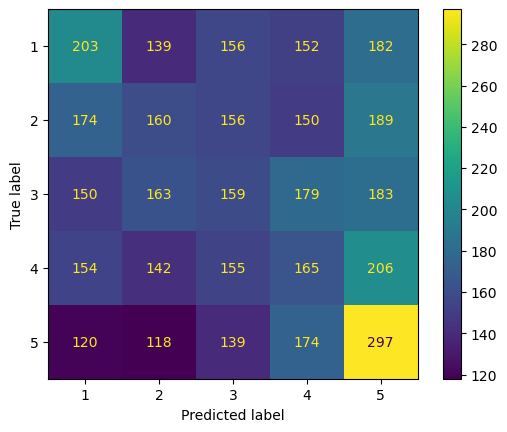

In [42]:
# import top-k accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# fit the model
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

# print the accuracy
print('Accuracy:', accuracy_score(y_test, y_pred))

# print the classification report
print(classification_report(y_test, y_pred))

# print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_clf.classes_)
disp.plot()
plt.show()